In [39]:
# data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from datetime import datetime
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [40]:
df = pd.read_csv('./data/household_power_consumption.txt',
                 parse_dates={'dt': ['Date', 'Time']},
                 sep=";", infer_datetime_format=True,
                 low_memory=False, na_values=['nan', '?'], index_col='dt')

In [41]:
# The first five lines of df is shown below
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [42]:
# resampling so that the frequency becomes hourly and taking mean
df = df.resample('H').mean()
# further resampling so that the frequency becomes daily and taking mean
df = df.resample('D').mean()
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16,3.120298,0.096233,236.152341,13.369524,0.000000,1.330159,12.692063
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308063,6.467361,0.000000,1.838889,9.765972


In [43]:
dataset_train_actual = df.copy()
dataset_train_actual.isnull().sum()

Global_active_power      9
Global_reactive_power    9
Voltage                  9
Global_intensity         9
Sub_metering_1           9
Sub_metering_2           9
Sub_metering_3           9
dtype: int64

In [44]:
dataset_train_actual = dataset_train_actual.fillna(dataset_train_actual.mean())
dataset_train_actual = dataset_train_actual.reset_index()
dataset_train_actual.isnull().sum()

dt                       0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [45]:
dataset_train_actual.head()

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,3.120298,0.096233,236.152341,13.369524,0.000000,1.330159,12.692063
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
3,2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
4,2006-12-20,1.545658,0.111804,242.308063,6.467361,0.000000,1.838889,9.765972


In [46]:
dataset_train_timeindex = dataset_train_actual.set_index('dt')
dataset_train = dataset_train_actual.copy()

In [47]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:8]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['dt'])
datelist_train = [date for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1442, 8)
All timestamps == 1442
Featured selected: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [48]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1442, 7).


array([[3.12029841e+00, 9.62333333e-02, 2.36152341e+02, ...,
        0.00000000e+00, 1.33015873e+00, 1.26920635e+01],
       [2.35448611e+00, 1.56948611e-01, 2.40087028e+02, ...,
        1.41180556e+00, 2.90763889e+00, 9.26458333e+00],
       [1.53043472e+00, 1.12355556e-01, 2.41231694e+02, ...,
        7.38194444e-01, 1.82013889e+00, 9.73472222e+00],
       ...,
       [1.24739444e+00, 9.19861111e-02, 2.40030965e+02, ...,
        7.61111111e-01, 1.97777778e+00, 8.48888889e+00],
       [9.93863889e-01, 8.06444444e-02, 2.41536257e+02, ...,
        7.47222222e-01, 2.95833333e-01, 3.52222222e+00],
       [1.16771212e+00, 9.15348485e-02, 2.40265076e+02, ...,
        8.18181818e-01, 2.91666667e-01, 7.56742424e+00]])

In [49]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[ 4.83789162, -0.81155418, -2.29744952, ..., -1.01171749,
         0.02172264,  2.43988366],
       [ 3.01106956,  0.97410919, -0.36734911, ...,  0.2605755 ,
         1.10514122,  1.10111841],
       [ 1.04531992, -0.33739244,  0.19414965, ..., -0.34647035,
         0.35824263,  1.28475349],
       ...,
       [ 0.37013591, -0.93646687, -0.39484972, ..., -0.32581827,
         0.46650954,  0.79813408],
       [-0.23465356, -1.27003034,  0.34354813, ..., -0.33833468,
        -0.68865545, -1.1418336 ],
       [ 0.18005614, -0.94973871, -0.2800104 , ..., -0.27438721,
        -0.69151713,  0.43821228]])

In [50]:
sc_predict = StandardScaler()
predict_scaled = sc_predict.fit_transform(training_set[:, 0:1])

In [51]:
# Creating a data structure with 72 timestamps and 1 output
X_train = []
y_train = []

n_future = 30  # Number of days we want top predict into the future
n_past = 72  # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(predict_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1341, 72, 7).
y_train shape == (1341, 1).


In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200),
])
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mse"])

In [53]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100


2022-02-18 21:27:07.565152: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


34/34 [==============================] - 5s 29ms/step - loss: 12.0417 - mse: 279.2401 - val_loss: 6.5631 - val_mse: 77.3394
Epoch 2/100
34/34 [==============================] - 0s 10ms/step - loss: 7.4879 - mse: 102.0846 - val_loss: 4.8572 - val_mse: 45.0390
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 6.2704 - mse: 74.9702 - val_loss: 3.7579 - val_mse: 29.6232
Epoch 4/100
34/34 [==============================] - 0s 10ms/step - loss: 5.4887 - mse: 58.7314 - val_loss: 3.6159 - val_mse: 25.1268
Epoch 5/100
34/34 [==============================] - 0s 10ms/step - loss: 4.9297 - mse: 47.5348 - val_loss: 2.9974 - val_mse: 19.3279
Epoch 6/100
34/34 [==============================] - 0s 10ms/step - loss: 4.5538 - mse: 41.3989 - val_loss: 4.1949 - val_mse: 35.1784
Epoch 7/100
34/34 [==============================] - 0s 10ms/step - loss: 4.1350 - mse: 33.9319 - val_loss: 3.5017 - val_mse: 26.8893
Epoch 8/100
34/34 [==============================] - 0s 10ms/step - los

In [54]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remember, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [55]:
datelist_train[-1]

Timestamp('2010-11-26 00:00:00')

In [56]:
datelist_future_

[datetime.date(2010, 11, 26),
 datetime.date(2010, 11, 27),
 datetime.date(2010, 11, 28),
 datetime.date(2010, 11, 29),
 datetime.date(2010, 11, 30),
 datetime.date(2010, 12, 1),
 datetime.date(2010, 12, 2),
 datetime.date(2010, 12, 3),
 datetime.date(2010, 12, 4),
 datetime.date(2010, 12, 5),
 datetime.date(2010, 12, 6),
 datetime.date(2010, 12, 7),
 datetime.date(2010, 12, 8),
 datetime.date(2010, 12, 9),
 datetime.date(2010, 12, 10),
 datetime.date(2010, 12, 11),
 datetime.date(2010, 12, 12),
 datetime.date(2010, 12, 13),
 datetime.date(2010, 12, 14),
 datetime.date(2010, 12, 15),
 datetime.date(2010, 12, 16),
 datetime.date(2010, 12, 17),
 datetime.date(2010, 12, 18),
 datetime.date(2010, 12, 19),
 datetime.date(2010, 12, 20),
 datetime.date(2010, 12, 21),
 datetime.date(2010, 12, 22),
 datetime.date(2010, 12, 23),
 datetime.date(2010, 12, 24),
 datetime.date(2010, 12, 25)]

In [57]:
# Perform predictions
predictions_future = model.predict_scaled(X_train[-n_future:])
predictions_train = model.predict_scaled(X_train[n_past:])

In [58]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Global_active_power']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Global_active_power']).set_index(
    pd.Series(datelist_train[2 * n_past + n_future - 1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
# PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

In [59]:
PREDICTIONS_FUTURE

,Global_active_power
2010-11-26,1.214462
2010-11-27,1.043354
2010-11-28,1.337699
2010-11-29,1.084604
2010-11-30,1.059080
2010-12-01,1.065734
2010-12-02,1.151762
2010-12-03,1.151611
2010-12-04,1.195165
2010-12-05,1.269988


In [60]:
PREDICTION_TRAIN

,Global_active_power
2007-06-07,0.880961
2007-06-08,0.788221
2007-06-09,0.691260
2007-06-10,0.869178
2007-06-11,0.598122
...,...
2010-11-22,1.282862
2010-11-23,1.482065
2010-11-24,1.513037
2010-11-25,0.778710


Text(0, 0.5, 'Power consumption Value')

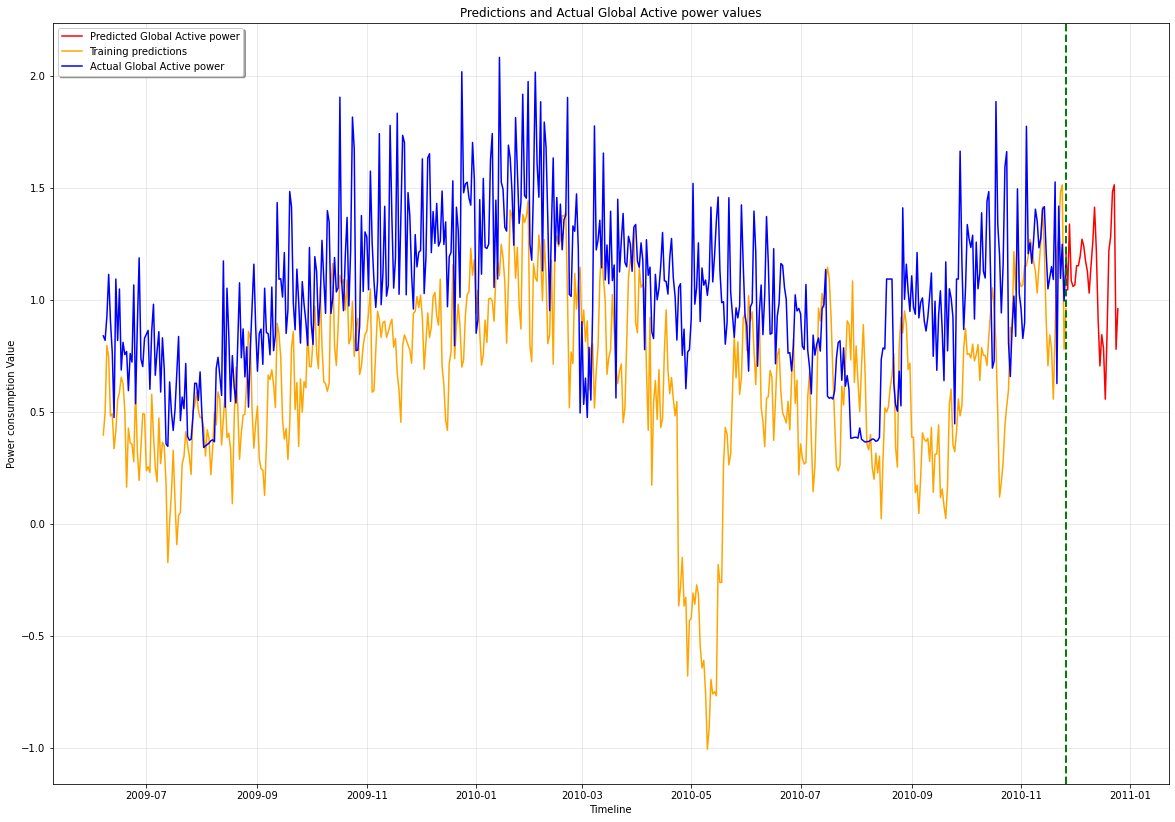

In [61]:
# Set plot size
# from pylab import rcParams
plt.rcParams['figure.figsize'] = 20, 14

# Plot parameters
START_DATE_FOR_PLOTTING = '2009-06-07'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Global_active_power'], color='r',
         label='Predicted Global Active power')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index,
         PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Global_active_power'], color='orange',
         label='Training predictions')
plt.plot(dataset_train_timeindex.loc[START_DATE_FOR_PLOTTING:].index,
         dataset_train_timeindex.loc[START_DATE_FOR_PLOTTING:]['Global_active_power'], color='b',
         label='Actual Global Active power')

plt.axvline(x=min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Global Active power values', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Power consumption Value', fontsize=10)
# plt.xticks(rotation=45, fontsize=8)
# plt.show()